In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from copy import deepcopy
import pylab as plt

from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',', )
y_train = np.loadtxt('y_train.csv', delimiter=',')
X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = pd.read_csv('y_test.csv', delimiter=',')['y']
pairs = [(0, 8), (1, 9), (2, 10), (3, 11)]

In [3]:
total_informative_features = 8
total_shit_features = 4
total_redundant_features = 4

def fix_row(row, pairs):
    row = row.copy()
    for fst, snd in pairs:
        fst += total_shit_features
        snd += total_shit_features
        row[fst], row[snd] = row[snd], row[fst]
    return row


def fix_dataset(X, pairs, truncate_informative=True):
    res = np.apply_along_axis(lambda x: fix_row(x, pairs), 1, X)
    if truncate_informative:
        return res[
            :, total_shit_features : total_shit_features + total_informative_features
        ]
    return res[:, :-total_redundant_features]

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((40000, 16), (40000,), (10000, 16), (10000,))

<Axes: >

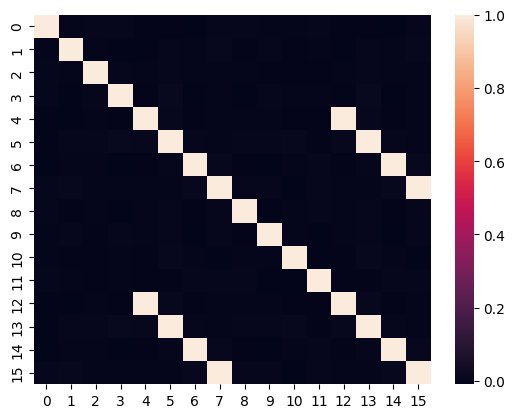

In [5]:
sns.heatmap(pd.DataFrame(X_train).corr())

<Axes: >

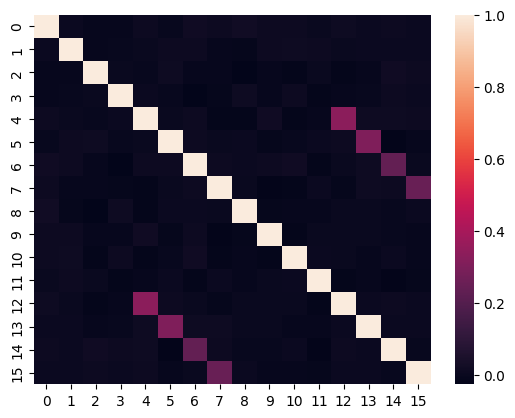

In [6]:
sns.heatmap(pd.DataFrame(X_test).corr())

In [7]:
def check(raw_clf):
    print('Raw train')
    clf = deepcopy(raw_clf)
    #print(cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', verbose=0))
    clf = deepcopy(raw_clf)

    clf.fit(X_train, y_train)
    print('corrupted_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test)))
    print('fixed_predict',mean_squared_error(y_true=y_test, y_pred=clf.predict(np.apply_along_axis(lambda x: fix_row(x, pairs), 1, X_test))))
    clf = deepcopy(raw_clf)
    print('\n\nFixed train')
    #print(cross_val_score(clf, fix_dataset(X_train, pairs), y_train, scoring='neg_mean_squared_error', verbose=0))
    clf = deepcopy(raw_clf)
    clf.fit(fix_dataset(X_train, pairs, truncate_informative=False), y_train)
    print('corrupted_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test[:,:-total_redundant_features])))
    print('fixed_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(fix_dataset(X_test, pairs, truncate_informative=False))))
    print('\n\nFull fixed train')
    #print(cross_val_score(clf, fix_dataset(X_train, pairs), y_train, scoring='neg_mean_squared_error', verbose=0))
    clf = deepcopy(raw_clf)
    clf.fit(fix_dataset(X_train, pairs), y_train)
    print('corrupted_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test[:, :total_informative_features])))
    print('fixed_predict', mean_squared_error(y_true=y_test, y_pred=clf.predict(fix_dataset(X_test, pairs))))

In [8]:
check(LGBMRegressor(verbose=-1))

Raw train
corrupted_predict 281.6765770024998
fixed_predict 1.087682069070324


Fixed train


/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/pyth

corrupted_predict 281.6765770024998
fixed_predict 1.087682069070324


Full fixed train
corrupted_predict 311.817539596847
fixed_predict 1.1244358854517607


/home/pankratov1996/Desktop/work/ml_contest_2025_1/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [9]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train
corrupted_predict 121.21912433858829
fixed_predict 121.21912433862111


Fixed train
corrupted_predict 269.979395761004
fixed_predict 13.500414775942945


Full fixed train
corrupted_predict 333.24172173654847
fixed_predict 13.494655962004227


In [10]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train
corrupted_predict 140.10047783253944
fixed_predict 140.10047783258912


Fixed train
corrupted_predict 283.83696101256663
fixed_predict 1.8280190669066612


Full fixed train
corrupted_predict 348.4998820579316
fixed_predict 1.8193835388114832


In [11]:
check(CatBoostRegressor(verbose=0, loss_function='RMSE'))

Raw train
corrupted_predict 105.43655317449759
fixed_predict 155.1497452814919


Fixed train
corrupted_predict 277.4978416948469
fixed_predict 0.04947303489075147


Full fixed train
corrupted_predict 339.19081760828766
fixed_predict 0.044137654768777186


In [12]:
check(XGBRegressor(objective='reg:squarederror'))

Raw train
corrupted_predict 279.1616651155271
fixed_predict 1.3590793128871388


Fixed train
corrupted_predict 279.1616651155271
fixed_predict 1.3590793128871388


Full fixed train
corrupted_predict 372.4616432222164
fixed_predict 1.258787601151929


In [13]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=True))])
check(model)

Raw train
corrupted_predict 163.86520187813454
fixed_predict 163.86520187598177


Fixed train
corrupted_predict 277.4560564706455
fixed_predict 8.667002595935251e-10


Full fixed train
corrupted_predict 345.1953566980684
fixed_predict 8.380399246503222e-10


In [14]:

model.fit(fix_dataset(X_train, pairs), y_train)
mean_squared_error(model.predict(fix_dataset(X_test, pairs)), y_test)

8.380399246503222e-10